In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
ld = pd.read_csv("Load_data.csv")
ld.head()

,Load
0,1001
1,967
2,946
3,939
4,934


17544

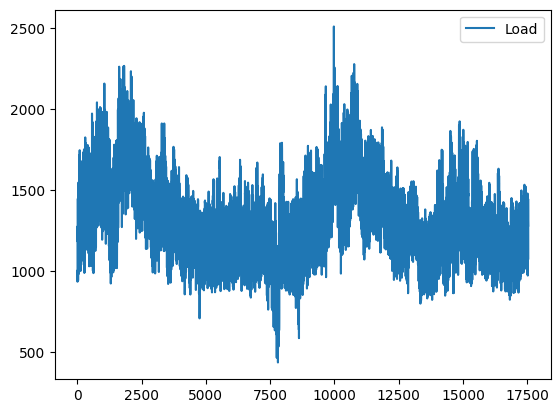

In [3]:
ld.plot()
ld.size

In [4]:
da = pd.date_range(start='11/1/2003', end='11/1/2005', periods=17545, closed='right')
r = np.array(da, dtype='datetime64[h]')
rr = pd.DataFrame(r, columns=['Time'])
rr.tail()


C:\Users\prede\AppData\Local\Temp\ipykernel_16880\1644015983.py:1: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  da = pd.date_range(start='11/1/2003', end='11/1/2005', periods=17545, closed='right')


,Time
17539,2005-10-31 20:00:00
17540,2005-10-31 21:00:00
17541,2005-10-31 22:00:00
17542,2005-10-31 23:00:00
17543,2005-11-01 00:00:00


In [5]:
ldd = pd.concat([rr, ld], axis=1)
ldd.Time = pd.to_datetime(ldd.Time)
print(ldd.info())
ldd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    17544 non-null  datetime64[ns]
 1   Load    17544 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 274.2 KB
None


,Time,Load
0,2003-11-01 01:00:00,1001
1,2003-11-01 02:00:00,967
2,2003-11-01 03:00:00,946
3,2003-11-01 04:00:00,939
4,2003-11-01 05:00:00,934


In [6]:
temp = pd.read_csv("temp.csv")
ldt = pd.concat([ldd, temp], axis=1)
ldt=ldt.set_index("Time")
ldt.head()
#The dataframe including the temperature data

,Load,Temp (C)
Time,,
2003-11-01 01:00:00,1001,16.8
2003-11-01 02:00:00,967,15.9
2003-11-01 03:00:00,946,15.9
2003-11-01 04:00:00,939,16.9
2003-11-01 05:00:00,934,16.3


In [7]:
#Generating the time in "Seconds" to generate a cos and sin map for periodicity relevance
ldt['Sec'] = ldt.index.map(pd.Timestamp.timestamp)
ldt

,Load,Temp (C),Sec
Time,,,
2003-11-01 01:00:00,1001,16.8,1.067648e+09
2003-11-01 02:00:00,967,15.9,1.067652e+09
2003-11-01 03:00:00,946,15.9,1.067656e+09
2003-11-01 04:00:00,939,16.9,1.067659e+09
2003-11-01 05:00:00,934,16.3,1.067663e+09
...,...,...,...
2005-10-31 20:00:00,1352,11.7,1.130789e+09
2005-10-31 21:00:00,1348,11.3,1.130792e+09
2005-10-31 22:00:00,1266,11.4,1.130796e+09


In [8]:
day = 86400 
#86400 is the number of seconds in a day
year = 31556952 
#31556952 is the number of seconds in an year

ldt['DSin'] = np.sin(ldt['Sec'] * (2*np.pi /day))
ldt['DCos'] = np.cos(ldt['Sec'] * (2*np.pi /day))
ldt['YSin'] = np.sin(ldt['Sec'] * (2*np.pi /year))
ldt['YCos'] = np.cos(ldt['Sec'] * (2*np.pi /year))
ldt.head()

,Load,Temp (C),Sec,DSin,DCos,YSin,YCos
Time,,,,,,,
2003-11-01 01:00:00,1001,16.8,1.067648e+09,0.258819,0.965926,-0.868846,0.495082
2003-11-01 02:00:00,967,15.9,1.067652e+09,0.500000,0.866025,-0.868491,0.495704
2003-11-01 03:00:00,946,15.9,1.067656e+09,0.707107,0.707107,-0.868136,0.496327
2003-11-01 04:00:00,939,16.9,1.067659e+09,0.866025,0.500000,-0.867780,0.496949
2003-11-01 05:00:00,934,16.3,1.067663e+09,0.965926,0.258819,-0.867423,0.497571


In [9]:
ldt =ldt.drop('Sec', axis=1)
ldt.head()
#Dropping the "Seconds" column

,Load,Temp (C),DSin,DCos,YSin,YCos
Time,,,,,,
2003-11-01 01:00:00,1001,16.8,0.258819,0.965926,-0.868846,0.495082
2003-11-01 02:00:00,967,15.9,0.500000,0.866025,-0.868491,0.495704
2003-11-01 03:00:00,946,15.9,0.707107,0.707107,-0.868136,0.496327
2003-11-01 04:00:00,939,16.9,0.866025,0.500000,-0.867780,0.496949
2003-11-01 05:00:00,934,16.3,0.965926,0.258819,-0.867423,0.497571


In [50]:
win = pd.concat([ldt['2003-12-01':'2004-02-29'],ldt['2004-12-01':'2005-02-28']])
frames = [ldt['2003-11-01':'2003-11-30'],ldt['2004-09-01':'2004-11-30'],ldt['2005-09-01':'2005-10-30']]
fal = pd.concat(frames)
spr = pd.concat([ldt['2004-03-01':'2004-05-31'],ldt['2005-03-01':'2005-05-31']])
sue = pd.concat([ldt['2004-06-01':'2004-08-31'],ldt['2005-06-01':'2005-08-31']])


win.to_csv('win.csv',index=False)
fal.to_csv('fal.csv',index=False)
spr.to_csv('spr.csv',index=False)
sue.to_csv('sum.csv',index=False)

In [49]:
len(sue['2004-06-01':'2004-08-31'])

2208

In [12]:
#We generate the sliding window which is required for the LSTM model. The window size can be arbitrary and can depend on the dataset. Here, we use 5 hours of previous data to predict the next hour, Hence the size of the window will be 5. This can also be changed later for further tweaks to increase the accuracy of the model.
def dataframe_win(df, w_size=7):
    df_np = df.to_numpy()
    X=[]
    y=[]
    for i in range(len(df_np)-w_size):
        row =[r for r in df_np[i:i+w_size]]
        X.append(row)
        label = df_np[i+w_size][0]
        y.append(label)
    return np.array(X), np.array(y)


# Winter season dataset training and prediction

In [13]:
X, y = dataframe_win(win)
X.shape, y.shape

((4337, 7, 6), (4337,))

In [14]:
X_train, y_train = X[:2184], y[:2184]
X_val, y_val = X[2184:3672], y[2184:3672]
X_test, y_test = X[3672:], y[3672:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2184, 7, 6), (2184,), (1488, 7, 6), (1488,), (665, 7, 6), (665,))

In [15]:
load_train_mean = np.mean(X_train[:, :, 0])
load_train_std = np.std(X_train[:, :, 0])

temp_train_mean = np.mean(X_train[:, :, 1])
temp_train_std = np.std(X_train[:, :, 1])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - load_train_mean) / load_train_std
  X[:, :, 1] = (X[:, :, 1] - temp_train_mean) / temp_train_std

def preprocess_output(y):
  y[:] = (y[:] - load_train_mean) / load_train_std
  return y


In [16]:
preprocess(X_train)
preprocess(X_val)
preprocess(X_test)
preprocess_output(y_train)
preprocess_output(y_val)
preprocess_output(y_test)

array([ 5.30451378e-01,  1.14593831e+00,  1.10225859e+00,  8.71947353e-01,
        5.38393145e-01,  2.64402188e-01,  1.05566850e-01, -9.29773213e-02,
       -2.20045591e-01, -1.88278524e-01,  2.16751587e-01,  9.55335905e-01,
        1.18167626e+00,  1.07049152e+00,  9.11656188e-01,  4.55004593e-01,
       -1.56511456e-01, -5.61541567e-01, -9.30833726e-01, -1.03407670e+00,
       -1.06187288e+00, -1.04201846e+00, -9.46717260e-01, -6.64784536e-01,
        1.21450384e-01,  7.01199366e-01,  6.69432298e-01,  7.40908200e-01,
        5.50305795e-01,  2.48518654e-01, -4.53267201e-02, -2.08132941e-01,
       -3.07405027e-01, -2.39900008e-01,  5.79162492e-02,  8.67976470e-01,
        1.06652064e+00,  9.99015623e-01,  8.16354985e-01,  3.12052789e-01,
       -2.87550610e-01, -8.75241358e-01, -1.09761083e+00, -1.22070822e+00,
       -1.25644617e+00, -1.24056263e+00, -1.19688292e+00, -9.50688143e-01,
       -3.19317677e-01,  2.56460421e-01,  4.47062826e-01,  4.78829893e-01,
        3.67645157e-01,  

In [17]:
model = Sequential()
model.add(InputLayer((7, 6)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________


In [19]:
cp = ModelCheckpoint('modelWIN_LSTM/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [26]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
66/69 [===========================>..] - ETA: 0s - loss: 0.0408 - root_mean_squared_error: 0.2019

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 18s 190ms/step - loss: 0.0405 - root_mean_squared_error: 0.2012 - val_loss: 0.1028 - val_root_mean_squared_error: 0.3207
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 0.0379 - root_mean_squared_error: 0.1946

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 12s 171ms/step - loss: 0.0379 - root_mean_squared_error: 0.1946 - val_loss: 0.1023 - val_root_mean_squared_error: 0.3198
Epoch 3/20
65/69 [===========================>..] - ETA: 0s - loss: 0.0361 - root_mean_squared_error: 0.1901

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 10s 150ms/step - loss: 0.0361 - root_mean_squared_error: 0.1899 - val_loss: 0.0999 - val_root_mean_squared_error: 0.3161
Epoch 4/20
68/69 [============================>.] - ETA: 0s - loss: 0.0347 - root_mean_squared_error: 0.1862

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 13s 190ms/step - loss: 0.0346 - root_mean_squared_error: 0.1861 - val_loss: 0.0999 - val_root_mean_squared_error: 0.3161
Epoch 5/20
67/69 [============================>.] - ETA: 0s - loss: 0.0338 - root_mean_squared_error: 0.1839

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 13s 193ms/step - loss: 0.0337 - root_mean_squared_error: 0.1836 - val_loss: 0.0981 - val_root_mean_squared_error: 0.3133
Epoch 6/20
69/69 [==============================] - 1s 20ms/step - loss: 0.0326 - root_mean_squared_error: 0.1805 - val_loss: 0.0983 - val_root_mean_squared_error: 0.3135
Epoch 7/20
66/69 [===========================>..] - ETA: 0s - loss: 0.0312 - root_mean_squared_error: 0.1767

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 12s 176ms/step - loss: 0.0313 - root_mean_squared_error: 0.1768 - val_loss: 0.0952 - val_root_mean_squared_error: 0.3085
Epoch 8/20
65/69 [===========================>..] - ETA: 0s - loss: 0.0311 - root_mean_squared_error: 0.1764

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 12s 170ms/step - loss: 0.0307 - root_mean_squared_error: 0.1753 - val_loss: 0.0949 - val_root_mean_squared_error: 0.3081
Epoch 9/20
69/69 [==============================] - 2s 23ms/step - loss: 0.0300 - root_mean_squared_error: 0.1733 - val_loss: 0.0952 - val_root_mean_squared_error: 0.3086
Epoch 10/20
65/69 [===========================>..] - ETA: 0s - loss: 0.0296 - root_mean_squared_error: 0.1721

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 12s 172ms/step - loss: 0.0295 - root_mean_squared_error: 0.1717 - val_loss: 0.0939 - val_root_mean_squared_error: 0.3064
Epoch 11/20
67/69 [============================>.] - ETA: 0s - loss: 0.0289 - root_mean_squared_error: 0.1700

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 12s 177ms/step - loss: 0.0288 - root_mean_squared_error: 0.1697 - val_loss: 0.0911 - val_root_mean_squared_error: 0.3019
Epoch 12/20
69/69 [==============================] - 2s 22ms/step - loss: 0.0283 - root_mean_squared_error: 0.1682 - val_loss: 0.0920 - val_root_mean_squared_error: 0.3033
Epoch 13/20
67/69 [============================>.] - ETA: 0s - loss: 0.0278 - root_mean_squared_error: 0.1668

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 11s 157ms/step - loss: 0.0278 - root_mean_squared_error: 0.1666 - val_loss: 0.0899 - val_root_mean_squared_error: 0.2998
Epoch 14/20
69/69 [==============================] - ETA: 0s - loss: 0.0277 - root_mean_squared_error: 0.1663

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 12s 176ms/step - loss: 0.0277 - root_mean_squared_error: 0.1663 - val_loss: 0.0896 - val_root_mean_squared_error: 0.2994
Epoch 15/20
69/69 [==============================] - ETA: 0s - loss: 0.0268 - root_mean_squared_error: 0.1636

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 11s 161ms/step - loss: 0.0268 - root_mean_squared_error: 0.1636 - val_loss: 0.0874 - val_root_mean_squared_error: 0.2956
Epoch 16/20
69/69 [==============================] - 1s 21ms/step - loss: 0.0266 - root_mean_squared_error: 0.1631 - val_loss: 0.0875 - val_root_mean_squared_error: 0.2959
Epoch 17/20
67/69 [============================>.] - ETA: 0s - loss: 0.0260 - root_mean_squared_error: 0.1613

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 10s 154ms/step - loss: 0.0263 - root_mean_squared_error: 0.1621 - val_loss: 0.0865 - val_root_mean_squared_error: 0.2941
Epoch 18/20
69/69 [==============================] - ETA: 0s - loss: 0.0261 - root_mean_squared_error: 0.1615

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 14s 207ms/step - loss: 0.0261 - root_mean_squared_error: 0.1615 - val_loss: 0.0860 - val_root_mean_squared_error: 0.2933
Epoch 19/20
69/69 [==============================] - ETA: 0s - loss: 0.0260 - root_mean_squared_error: 0.1613

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 12s 178ms/step - loss: 0.0260 - root_mean_squared_error: 0.1613 - val_loss: 0.0852 - val_root_mean_squared_error: 0.2920
Epoch 20/20
68/69 [============================>.] - ETA: 0s - loss: 0.0255 - root_mean_squared_error: 0.1597

INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


INFO:tensorflow:Assets written to: modelWIN_LSTM\assets


69/69 [==============================] - 13s 191ms/step - loss: 0.0256 - root_mean_squared_error: 0.1599 - val_loss: 0.0850 - val_root_mean_squared_error: 0.2916


In [27]:
from tensorflow.keras.models import load_model
model = load_model('modelWIN_LSTM/')

21/21 [==============================] - 1s 4ms/step


<AxesSubplot: xlabel='Time'>

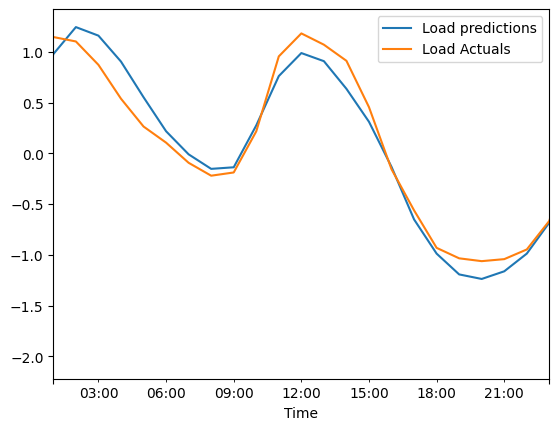

In [28]:
l_preds = model.predict(X_test).flatten()
l_actuals = y_test

df = pd.DataFrame(data={'Load predictions': l_preds,
                          'Load Actuals':l_actuals,  })

#df.plot(xlim=[100,200])

temp=ldt['2005-02-01':'2005-02-28']
feb=temp.reset_index()

# pd.concat([df.set_index(cols).value for df in dfs],axis=1, keys=keys)
winter= pd.concat([feb,df], axis=1)
winter.set_index("Time")
winter.plot(x='Time',y=['Load predictions', "Load Actuals"], xlim=[dt.datetime(2005,2,1,1,0,0),dt.datetime(2005,2,1,23,0,0)])

# Spring season dataset training and prediction

In [102]:
X, y = dataframe_win(spr)
X.shape, y.shape

((4409, 7, 6), (4409,))

In [34]:
X_train, y_train = X[:2208], y[:2208]
X_val, y_val = X[2208:3672], y[2208:3672]
X_test, y_test = X[3672:], y[3672:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2208, 7, 6), (2208,), (1464, 7, 6), (1464,), (665, 7, 6), (665,))

In [35]:
load_train_mean = np.mean(X_train[:, :, 0])
load_train_std = np.std(X_train[:, :, 0])

temp_train_mean = np.mean(X_train[:, :, 1])
temp_train_std = np.std(X_train[:, :, 1])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - load_train_mean) / load_train_std
  X[:, :, 1] = (X[:, :, 1] - temp_train_mean) / temp_train_std

def preprocess_output(y):
  y[:] = (y[:] - load_train_mean) / load_train_std
  


In [36]:
preprocess(X_train)
preprocess(X_val)
preprocess(X_test)
preprocess_output(y_train)
preprocess_output(y_val)
preprocess_output(y_test)

In [37]:
model = Sequential()
model.add(InputLayer((7, 6)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18176     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________


In [38]:
cp = ModelCheckpoint('modelSPR_LSTM/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [40]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
63/69 [==========================>...] - ETA: 0s - loss: 0.1245 - root_mean_squared_error: 0.3528

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 12s 173ms/step - loss: 0.1234 - root_mean_squared_error: 0.3513 - val_loss: 0.1745 - val_root_mean_squared_error: 0.4178
Epoch 2/20
65/69 [===========================>..] - ETA: 0s - loss: 0.1101 - root_mean_squared_error: 0.3318

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 11s 158ms/step - loss: 0.1092 - root_mean_squared_error: 0.3305 - val_loss: 0.1648 - val_root_mean_squared_error: 0.4060
Epoch 3/20
65/69 [===========================>..] - ETA: 0s - loss: 0.0967 - root_mean_squared_error: 0.3110

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 10s 153ms/step - loss: 0.0973 - root_mean_squared_error: 0.3119 - val_loss: 0.1566 - val_root_mean_squared_error: 0.3957
Epoch 4/20
68/69 [============================>.] - ETA: 0s - loss: 0.0872 - root_mean_squared_error: 0.2952

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 10s 151ms/step - loss: 0.0870 - root_mean_squared_error: 0.2950 - val_loss: 0.1484 - val_root_mean_squared_error: 0.3853
Epoch 5/20
69/69 [==============================] - ETA: 0s - loss: 0.0781 - root_mean_squared_error: 0.2794

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 13s 191ms/step - loss: 0.0781 - root_mean_squared_error: 0.2794 - val_loss: 0.1389 - val_root_mean_squared_error: 0.3726
Epoch 6/20
64/69 [==========================>...] - ETA: 0s - loss: 0.0705 - root_mean_squared_error: 0.2655

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 11s 160ms/step - loss: 0.0706 - root_mean_squared_error: 0.2657 - val_loss: 0.1359 - val_root_mean_squared_error: 0.3686
Epoch 7/20
66/69 [===========================>..] - ETA: 0s - loss: 0.0647 - root_mean_squared_error: 0.2543

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 11s 168ms/step - loss: 0.0647 - root_mean_squared_error: 0.2543 - val_loss: 0.1301 - val_root_mean_squared_error: 0.3607
Epoch 8/20
68/69 [============================>.] - ETA: 0s - loss: 0.0594 - root_mean_squared_error: 0.2437

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 11s 167ms/step - loss: 0.0592 - root_mean_squared_error: 0.2434 - val_loss: 0.1258 - val_root_mean_squared_error: 0.3547
Epoch 9/20
67/69 [============================>.] - ETA: 0s - loss: 0.0544 - root_mean_squared_error: 0.2332

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 10s 150ms/step - loss: 0.0549 - root_mean_squared_error: 0.2342 - val_loss: 0.1206 - val_root_mean_squared_error: 0.3473
Epoch 10/20
69/69 [==============================] - ETA: 0s - loss: 0.0511 - root_mean_squared_error: 0.2260

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 9s 132ms/step - loss: 0.0511 - root_mean_squared_error: 0.2260 - val_loss: 0.1179 - val_root_mean_squared_error: 0.3433
Epoch 11/20
66/69 [===========================>..] - ETA: 0s - loss: 0.0480 - root_mean_squared_error: 0.2192

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 9s 131ms/step - loss: 0.0479 - root_mean_squared_error: 0.2188 - val_loss: 0.1131 - val_root_mean_squared_error: 0.3364
Epoch 12/20
69/69 [==============================] - ETA: 0s - loss: 0.0453 - root_mean_squared_error: 0.2130

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 10s 152ms/step - loss: 0.0453 - root_mean_squared_error: 0.2130 - val_loss: 0.1102 - val_root_mean_squared_error: 0.3320
Epoch 13/20
66/69 [===========================>..] - ETA: 0s - loss: 0.0431 - root_mean_squared_error: 0.2076

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 10s 151ms/step - loss: 0.0431 - root_mean_squared_error: 0.2076 - val_loss: 0.1083 - val_root_mean_squared_error: 0.3291
Epoch 14/20
66/69 [===========================>..] - ETA: 0s - loss: 0.0415 - root_mean_squared_error: 0.2037

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 11s 155ms/step - loss: 0.0413 - root_mean_squared_error: 0.2031 - val_loss: 0.1054 - val_root_mean_squared_error: 0.3247
Epoch 15/20
67/69 [============================>.] - ETA: 0s - loss: 0.0400 - root_mean_squared_error: 0.2000

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 9s 136ms/step - loss: 0.0399 - root_mean_squared_error: 0.1999 - val_loss: 0.1043 - val_root_mean_squared_error: 0.3230
Epoch 16/20
69/69 [==============================] - ETA: 0s - loss: 0.0385 - root_mean_squared_error: 0.1962

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 10s 147ms/step - loss: 0.0385 - root_mean_squared_error: 0.1962 - val_loss: 0.1035 - val_root_mean_squared_error: 0.3217
Epoch 17/20
69/69 [==============================] - 2s 26ms/step - loss: 0.0372 - root_mean_squared_error: 0.1928 - val_loss: 0.1036 - val_root_mean_squared_error: 0.3219
Epoch 18/20
67/69 [============================>.] - ETA: 0s - loss: 0.0368 - root_mean_squared_error: 0.1917

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 9s 138ms/step - loss: 0.0368 - root_mean_squared_error: 0.1917 - val_loss: 0.1003 - val_root_mean_squared_error: 0.3167
Epoch 19/20
64/69 [==========================>...] - ETA: 0s - loss: 0.0356 - root_mean_squared_error: 0.1887

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 10s 141ms/step - loss: 0.0356 - root_mean_squared_error: 0.1888 - val_loss: 0.0994 - val_root_mean_squared_error: 0.3153
Epoch 20/20
68/69 [============================>.] - ETA: 0s - loss: 0.0351 - root_mean_squared_error: 0.1875

INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


INFO:tensorflow:Assets written to: modelSPR_LSTM\assets


69/69 [==============================] - 10s 147ms/step - loss: 0.0349 - root_mean_squared_error: 0.1868 - val_loss: 0.0956 - val_root_mean_squared_error: 0.3091


In [41]:
from tensorflow.keras.models import load_model
model = load_model('modelSPR_LSTM/')

21/21 [==============================] - 0s 13ms/step


<AxesSubplot: xlabel='Time'>

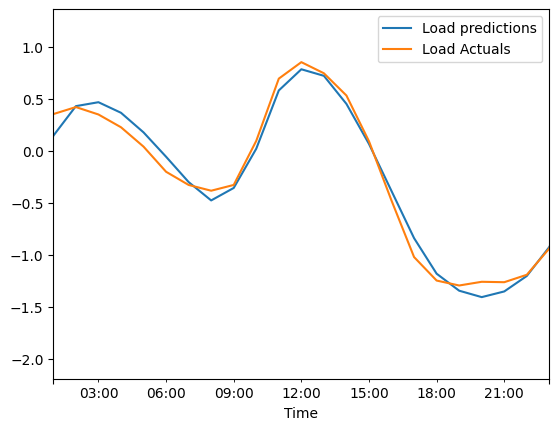

In [43]:
l_preds = model.predict(X_test).flatten()
l_actuals = y_test

df = pd.DataFrame(data={'Load predictions': l_preds,
                          'Load Actuals':l_actuals,  })

#df.plot(xlim=[100,200])

temp=ldt['2005-05-01':'2005-05-31']
may=temp.reset_index()

# pd.concat([df.set_index(cols).value for df in dfs],axis=1, keys=keys)
spring= pd.concat([may,df], axis=1)
spring.set_index("Time")
spring.plot(x='Time',y=['Load predictions', "Load Actuals"], xlim=[dt.datetime(2005,5,10,1,0,0),dt.datetime(2005,5,10,23,0,0)])

# Summer season dataset training and prediction

In [51]:
X, y = dataframe_win(sue)
X.shape, y.shape

((4409, 7, 6), (4409,))

In [52]:
X_train, y_train = X[:2208], y[:2208]
X_val, y_val = X[2208:3672], y[2208:3672]
X_test, y_test = X[3672:], y[3672:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2208, 7, 6), (2208,), (1464, 7, 6), (1464,), (737, 7, 6), (737,))

In [53]:
load_train_mean = np.mean(X_train[:, :, 0])
load_train_std = np.std(X_train[:, :, 0])

temp_train_mean = np.mean(X_train[:, :, 1])
temp_train_std = np.std(X_train[:, :, 1])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - load_train_mean) / load_train_std
  X[:, :, 1] = (X[:, :, 1] - temp_train_mean) / temp_train_std

def preprocess_output(y):
  y[:] = (y[:] - load_train_mean) / load_train_std
  return y


In [54]:
preprocess(X_train)
preprocess(X_val)
preprocess(X_test)
preprocess_output(y_train)
preprocess_output(y_val)
preprocess_output(y_test)

array([-1.19536883e+00, -6.76875404e-01, -8.35478716e-02,  2.42515007e-01,
        5.95304350e-01,  7.50317850e-01,  7.87734902e-01,  8.35842539e-01,
        8.35842539e-01,  1.02292780e+00,  1.08707131e+00,  1.09241661e+00,
        9.48093694e-01,  9.32057815e-01,  9.26712522e-01,  3.86837920e-01,
       -2.86669009e-01, -9.28104179e-01, -1.16329708e+00, -1.31831057e+00,
       -1.44125232e+00, -1.48401466e+00, -1.21675001e+00, -7.89126559e-01,
       -1.26310216e-01,  5.41851420e-01,  1.27950187e+00,  1.73919707e+00,
        1.95300879e+00,  2.11336759e+00,  2.22027345e+00,  2.29510755e+00,
        2.41270400e+00,  2.62117043e+00,  2.74945746e+00,  2.58909867e+00,
        2.19889228e+00,  1.94766350e+00,  1.89421057e+00,  1.22070364e+00,
        5.36506126e-01, -1.40590615e-02, -4.36337215e-01, -6.39458353e-01,
       -8.42579490e-01, -8.85341835e-01, -6.44803646e-01, -3.40121940e-01,
        2.58550886e-01,  8.51878419e-01,  1.50400418e+00,  1.96904467e+00,
        2.35925107e+00,  

In [55]:
model = Sequential()
model.add(InputLayer((7, 6)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18176     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________


In [56]:
cp = ModelCheckpoint('modelSUE_LSTM/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [57]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
66/69 [===========================>..] - ETA: 0s - loss: 0.8129 - root_mean_squared_error: 0.9016

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 6s 67ms/step - loss: 0.8077 - root_mean_squared_error: 0.8987 - val_loss: 1.2440 - val_root_mean_squared_error: 1.1153
Epoch 2/20
64/69 [==========================>...] - ETA: 0s - loss: 0.5327 - root_mean_squared_error: 0.7299

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 5s 67ms/step - loss: 0.5270 - root_mean_squared_error: 0.7260 - val_loss: 0.8113 - val_root_mean_squared_error: 0.9007
Epoch 3/20
62/69 [=========================>....] - ETA: 0s - loss: 0.3230 - root_mean_squared_error: 0.5683

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 4s 62ms/step - loss: 0.3143 - root_mean_squared_error: 0.5607 - val_loss: 0.5003 - val_root_mean_squared_error: 0.7073
Epoch 4/20
62/69 [=========================>....] - ETA: 0s - loss: 0.2008 - root_mean_squared_error: 0.4481

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 4s 59ms/step - loss: 0.1962 - root_mean_squared_error: 0.4429 - val_loss: 0.3519 - val_root_mean_squared_error: 0.5932
Epoch 5/20
63/69 [==========================>...] - ETA: 0s - loss: 0.1475 - root_mean_squared_error: 0.3840

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 4s 62ms/step - loss: 0.1471 - root_mean_squared_error: 0.3836 - val_loss: 0.2868 - val_root_mean_squared_error: 0.5355
Epoch 6/20
62/69 [=========================>....] - ETA: 0s - loss: 0.1237 - root_mean_squared_error: 0.3517

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 5s 71ms/step - loss: 0.1204 - root_mean_squared_error: 0.3470 - val_loss: 0.2552 - val_root_mean_squared_error: 0.5052
Epoch 7/20
61/69 [=========================>....] - ETA: 0s - loss: 0.1036 - root_mean_squared_error: 0.3218

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 4s 63ms/step - loss: 0.1026 - root_mean_squared_error: 0.3202 - val_loss: 0.2233 - val_root_mean_squared_error: 0.4726
Epoch 8/20
69/69 [==============================] - ETA: 0s - loss: 0.0904 - root_mean_squared_error: 0.3006

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 4s 65ms/step - loss: 0.0904 - root_mean_squared_error: 0.3006 - val_loss: 0.1987 - val_root_mean_squared_error: 0.4458
Epoch 9/20
68/69 [============================>.] - ETA: 0s - loss: 0.0813 - root_mean_squared_error: 0.2851

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 4s 60ms/step - loss: 0.0811 - root_mean_squared_error: 0.2847 - val_loss: 0.1689 - val_root_mean_squared_error: 0.4110
Epoch 10/20
66/69 [===========================>..] - ETA: 0s - loss: 0.0724 - root_mean_squared_error: 0.2691

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 5s 69ms/step - loss: 0.0731 - root_mean_squared_error: 0.2703 - val_loss: 0.1467 - val_root_mean_squared_error: 0.3830
Epoch 11/20
65/69 [===========================>..] - ETA: 0s - loss: 0.0668 - root_mean_squared_error: 0.2585

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 4s 66ms/step - loss: 0.0666 - root_mean_squared_error: 0.2581 - val_loss: 0.1300 - val_root_mean_squared_error: 0.3605
Epoch 12/20
65/69 [===========================>..] - ETA: 0s - loss: 0.0612 - root_mean_squared_error: 0.2475

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 4s 63ms/step - loss: 0.0612 - root_mean_squared_error: 0.2474 - val_loss: 0.1180 - val_root_mean_squared_error: 0.3435
Epoch 13/20
68/69 [============================>.] - ETA: 0s - loss: 0.0568 - root_mean_squared_error: 0.2383

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 4s 63ms/step - loss: 0.0568 - root_mean_squared_error: 0.2382 - val_loss: 0.1027 - val_root_mean_squared_error: 0.3204
Epoch 14/20
65/69 [===========================>..] - ETA: 0s - loss: 0.0534 - root_mean_squared_error: 0.2310

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 5s 73ms/step - loss: 0.0538 - root_mean_squared_error: 0.2320 - val_loss: 0.0960 - val_root_mean_squared_error: 0.3099
Epoch 15/20
61/69 [=========================>....] - ETA: 0s - loss: 0.0521 - root_mean_squared_error: 0.2283

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 4s 61ms/step - loss: 0.0509 - root_mean_squared_error: 0.2257 - val_loss: 0.0900 - val_root_mean_squared_error: 0.3001
Epoch 16/20
69/69 [==============================] - ETA: 0s - loss: 0.0492 - root_mean_squared_error: 0.2219

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 4s 64ms/step - loss: 0.0492 - root_mean_squared_error: 0.2219 - val_loss: 0.0870 - val_root_mean_squared_error: 0.2949
Epoch 17/20
63/69 [==========================>...] - ETA: 0s - loss: 0.0483 - root_mean_squared_error: 0.2198

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 4s 61ms/step - loss: 0.0474 - root_mean_squared_error: 0.2177 - val_loss: 0.0816 - val_root_mean_squared_error: 0.2856
Epoch 18/20
69/69 [==============================] - 1s 9ms/step - loss: 0.0461 - root_mean_squared_error: 0.2147 - val_loss: 0.0816 - val_root_mean_squared_error: 0.2856
Epoch 19/20
68/69 [============================>.] - ETA: 0s - loss: 0.0449 - root_mean_squared_error: 0.2118

INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


INFO:tensorflow:Assets written to: modelSUE_LSTM\assets


69/69 [==============================] - 5s 70ms/step - loss: 0.0448 - root_mean_squared_error: 0.2116 - val_loss: 0.0778 - val_root_mean_squared_error: 0.2790
Epoch 20/20
69/69 [==============================] - 1s 8ms/step - loss: 0.0439 - root_mean_squared_error: 0.2095 - val_loss: 0.0807 - val_root_mean_squared_error: 0.2840


In [58]:
from tensorflow.keras.models import load_model
model = load_model('modelSUE_LSTM/')

24/24 [==============================] - 0s 3ms/step


<AxesSubplot: xlabel='Time'>

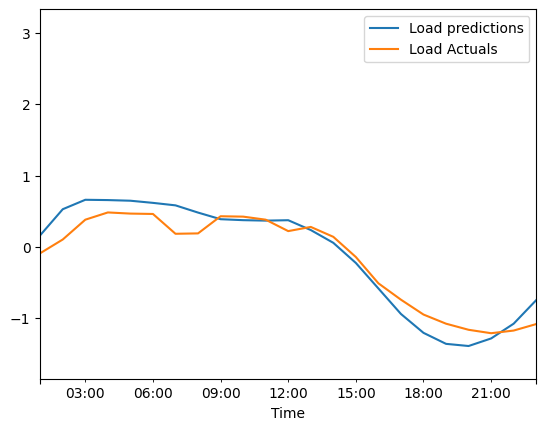

In [66]:
l_preds = model.predict(X_test).flatten()
l_actuals = y_test

df = pd.DataFrame(data={'Load predictions': l_preds,
                          'Load Actuals':l_actuals,  })

#df.plot(xlim=[100,200])

temp=ldt['2005-08-01':'2005-08-31']
aug=temp.reset_index()

# pd.concat([df.set_index(cols).value for df in dfs],axis=1, keys=keys)
summer= pd.concat([aug,df], axis=1)
summer.set_index("Time")
summer.plot(x='Time',y=['Load predictions', "Load Actuals"], xlim=[dt.datetime(2005,8,20,1,0,0),dt.datetime(2005,8,20,23,0,0)])


# Fall season dataset training and prediction

In [67]:
X, y = dataframe_win(fal)
X.shape, y.shape

((4336, 7, 6), (4336,))

In [68]:
X_train, y_train = X[:2184], y[:2184]
X_val, y_val = X[2184:3678], y[2184:3678]
X_test, y_test = X[3678:], y[3678:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2184, 7, 6), (2184,), (1494, 7, 6), (1494,), (658, 7, 6), (658,))

In [69]:
load_train_mean = np.mean(X_train[:, :, 0])
load_train_std = np.std(X_train[:, :, 0])

temp_train_mean = np.mean(X_train[:, :, 1])
temp_train_std = np.std(X_train[:, :, 1])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - load_train_mean) / load_train_std
  X[:, :, 1] = (X[:, :, 1] - temp_train_mean) / temp_train_std

def preprocess_output(y):
  y[:] = (y[:] - load_train_mean) / load_train_std
  return y


In [70]:
preprocess(X_train)
preprocess(X_val)
preprocess(X_test)
preprocess_output(y_train)
preprocess_output(y_val)
preprocess_output(y_test)

array([ 9.50942827e-02,  1.82489370e-01,  4.60564650e-01,  5.91657281e-01,
        5.24124713e-01,  7.06859897e-01,  5.71794761e-01,  2.46049434e-01,
       -1.75035988e-01, -5.92148907e-01, -8.42416658e-01, -9.85426802e-01,
       -1.04898687e+00, -1.11254693e+00, -1.11651943e+00, -9.69536786e-01,
       -4.69001284e-01, -7.17508848e-02,  6.72867548e-02,  7.52317628e-02,
        7.12592588e-02,  1.03039291e-01,  5.53692429e-02,  6.72867548e-02,
        1.18929307e-01,  1.82489370e-01,  4.68509658e-01,  7.18777409e-01,
        6.90969881e-01,  9.37265128e-01,  7.62474953e-01,  4.20839610e-01,
       -7.57233888e-02, -5.12698827e-01, -7.86801603e-01, -9.33784250e-01,
       -1.03706935e+00, -1.09268441e+00, -1.08473940e+00, -8.98031714e-01,
       -4.37221252e-01, -5.18883648e-02, -1.61358289e-02,  5.53692429e-02,
        1.10984299e-01,  1.78516866e-01,  2.06324394e-01,  2.53994442e-01,
        2.85774474e-01,  4.16867106e-01,  5.71794761e-01,  6.43299833e-01,
        6.11519801e-01,  

In [71]:
model = Sequential()
model.add(InputLayer((7, 6)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                18176     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________


In [72]:
cp = ModelCheckpoint('modelFAL_LSTM/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [74]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
61/69 [=========================>....] - ETA: 0s - loss: 0.5458 - root_mean_squared_error: 0.7388

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 59ms/step - loss: 0.5411 - root_mean_squared_error: 0.7356 - val_loss: 0.2484 - val_root_mean_squared_error: 0.4984
Epoch 2/20
63/69 [==========================>...] - ETA: 0s - loss: 0.3590 - root_mean_squared_error: 0.5992

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 61ms/step - loss: 0.3562 - root_mean_squared_error: 0.5968 - val_loss: 0.1838 - val_root_mean_squared_error: 0.4287
Epoch 3/20
67/69 [============================>.] - ETA: 0s - loss: 0.2677 - root_mean_squared_error: 0.5174

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 64ms/step - loss: 0.2661 - root_mean_squared_error: 0.5158 - val_loss: 0.1585 - val_root_mean_squared_error: 0.3981
Epoch 4/20
63/69 [==========================>...] - ETA: 0s - loss: 0.2272 - root_mean_squared_error: 0.4766

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 5s 73ms/step - loss: 0.2258 - root_mean_squared_error: 0.4752 - val_loss: 0.1399 - val_root_mean_squared_error: 0.3741
Epoch 5/20
67/69 [============================>.] - ETA: 0s - loss: 0.2019 - root_mean_squared_error: 0.4494

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 64ms/step - loss: 0.2006 - root_mean_squared_error: 0.4479 - val_loss: 0.1238 - val_root_mean_squared_error: 0.3519
Epoch 6/20
67/69 [============================>.] - ETA: 0s - loss: 0.1800 - root_mean_squared_error: 0.4243

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 60ms/step - loss: 0.1799 - root_mean_squared_error: 0.4241 - val_loss: 0.1094 - val_root_mean_squared_error: 0.3308
Epoch 7/20
66/69 [===========================>..] - ETA: 0s - loss: 0.1621 - root_mean_squared_error: 0.4026

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 61ms/step - loss: 0.1620 - root_mean_squared_error: 0.4025 - val_loss: 0.1034 - val_root_mean_squared_error: 0.3216
Epoch 8/20
69/69 [==============================] - ETA: 0s - loss: 0.1452 - root_mean_squared_error: 0.3810

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 5s 68ms/step - loss: 0.1452 - root_mean_squared_error: 0.3810 - val_loss: 0.0908 - val_root_mean_squared_error: 0.3013
Epoch 9/20
65/69 [===========================>..] - ETA: 0s - loss: 0.1302 - root_mean_squared_error: 0.3609

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 62ms/step - loss: 0.1299 - root_mean_squared_error: 0.3604 - val_loss: 0.0806 - val_root_mean_squared_error: 0.2838
Epoch 10/20
62/69 [=========================>....] - ETA: 0s - loss: 0.1175 - root_mean_squared_error: 0.3428

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 5s 66ms/step - loss: 0.1175 - root_mean_squared_error: 0.3428 - val_loss: 0.0733 - val_root_mean_squared_error: 0.2707
Epoch 11/20
63/69 [==========================>...] - ETA: 0s - loss: 0.1064 - root_mean_squared_error: 0.3262

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 64ms/step - loss: 0.1068 - root_mean_squared_error: 0.3267 - val_loss: 0.0646 - val_root_mean_squared_error: 0.2541
Epoch 12/20
61/69 [=========================>....] - ETA: 0s - loss: 0.0993 - root_mean_squared_error: 0.3151

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 5s 69ms/step - loss: 0.0984 - root_mean_squared_error: 0.3137 - val_loss: 0.0576 - val_root_mean_squared_error: 0.2400
Epoch 13/20
61/69 [=========================>....] - ETA: 0s - loss: 0.0909 - root_mean_squared_error: 0.3015

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 65ms/step - loss: 0.0919 - root_mean_squared_error: 0.3032 - val_loss: 0.0520 - val_root_mean_squared_error: 0.2280
Epoch 14/20
69/69 [==============================] - ETA: 0s - loss: 0.0864 - root_mean_squared_error: 0.2939

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 62ms/step - loss: 0.0864 - root_mean_squared_error: 0.2939 - val_loss: 0.0502 - val_root_mean_squared_error: 0.2240
Epoch 15/20
63/69 [==========================>...] - ETA: 0s - loss: 0.0824 - root_mean_squared_error: 0.2870

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 62ms/step - loss: 0.0822 - root_mean_squared_error: 0.2868 - val_loss: 0.0461 - val_root_mean_squared_error: 0.2148
Epoch 16/20
69/69 [==============================] - ETA: 0s - loss: 0.0789 - root_mean_squared_error: 0.2809

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 60ms/step - loss: 0.0789 - root_mean_squared_error: 0.2809 - val_loss: 0.0425 - val_root_mean_squared_error: 0.2061
Epoch 17/20
68/69 [============================>.] - ETA: 0s - loss: 0.0765 - root_mean_squared_error: 0.2766

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 5s 74ms/step - loss: 0.0765 - root_mean_squared_error: 0.2766 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2039
Epoch 18/20
63/69 [==========================>...] - ETA: 0s - loss: 0.0707 - root_mean_squared_error: 0.2660

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 63ms/step - loss: 0.0737 - root_mean_squared_error: 0.2715 - val_loss: 0.0407 - val_root_mean_squared_error: 0.2018
Epoch 19/20
65/69 [===========================>..] - ETA: 0s - loss: 0.0713 - root_mean_squared_error: 0.2670

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 62ms/step - loss: 0.0716 - root_mean_squared_error: 0.2676 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1924
Epoch 20/20
67/69 [============================>.] - ETA: 0s - loss: 0.0697 - root_mean_squared_error: 0.2640

INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


INFO:tensorflow:Assets written to: modelFAL_LSTM\assets


69/69 [==============================] - 4s 63ms/step - loss: 0.0700 - root_mean_squared_error: 0.2645 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873


In [75]:
from tensorflow.keras.models import load_model
model = load_model('modelFAL_LSTM/')

21/21 [==============================] - 0s 4ms/step


<AxesSubplot: xlabel='Time'>

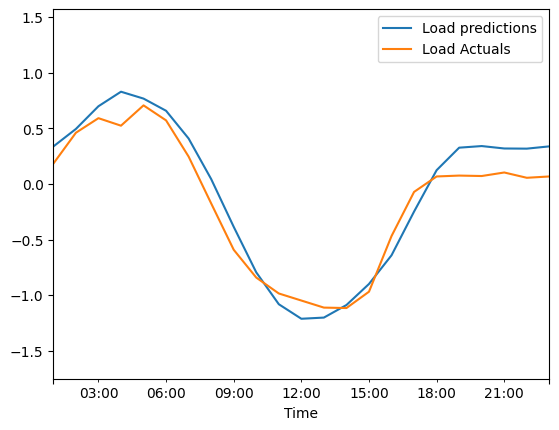

In [78]:
l_preds = model.predict(X_test).flatten()
l_actuals = y_test

df = pd.DataFrame(data={'Load predictions': l_preds,
                          'Load Actuals':l_actuals,  })

#df.plot(xlim=[100,200])

temp=ldt['2005-10-01':'2005-10-30']
nov=temp.reset_index()

# pd.concat([df.set_index(cols).value for df in dfs],axis=1, keys=keys)
fall= pd.concat([nov,df], axis=1)
fall.set_index("Time")
fall.plot(x='Time',y=['Load predictions', "Load Actuals"], xlim=[dt.datetime(2005,10,1,1,0,0),dt.datetime(2005,10,1,23,0,0)])